In [216]:
import numpy as np

def to_tensor(np_array: np.array, size=None) -> torch.tensor:
    torch_tensor = torch.from_numpy(np_array).float()
    if size is not None:
        torch_tensor = torch_tensor.view(size)
    return torch_tensor


def to_numpy(torch_tensor: torch.tensor) -> np.array:
    return torch_tensor.cpu().detach().numpy()


class EMAMeter:

    def __init__(self,
                 alpha: float = 0.5):
        self.s = None
        self.alpha = alpha

    def update(self, y):
        if self.s is None:
            self.s = y
        else:
            self.s = self.alpha * y + (1 - self.alpha) * self.s

In [214]:
b_skills = [
    {'idx':0,
     'name':'kick',
     'damage':25,
     'cool':2,
     'hit_rate':0.9
    },
    {'idx':1,
     'name':'punch',
     'damage':10,
     'cool':1,
     'hit_rate':1.0
    }
]

p_skills = [
    {'idx':0,
     'name':'kick',
     'damage':25,
     'cool':2,
     'hit_rate':0.9
    },
    {'idx':1,
     'name':'punch',
     'damage':10,
     'cool':1,
     'hit_rate':1.0
    },
    {'idx':2,
     'name':'jump',
     'damage':0,
     'cool':1,
     'hit_rate':1.0
    },
    {'idx':3,
     'name':'heal',
     'damage':0,
     'cool':5,
     'hit_rate':1.0
    }
]

In [308]:
class boss_raid_simulater():
    def __init__(self, b_skills, p_skills):
        
        self.num_bs = len(b_skills)
        self.num_ps = len(p_skills)
        
        self.state_dict = dict()
        self.state_dict['b_hp'] = 100
        for i in range(len(b_skills)):
            self.state_dict[f'b_cool_{i}'] = 0
        self.b_skills = b_skills
        
        self.state_dict['p_hp'] = 100
        for i in range(len(p_skills)):
            self.state_dict[f'p_cool_{i}'] = 0
        self.p_skills = p_skills
        
        self.state = np.array(list(self.state_dict.values()))
        
        self.done = 0
        
        self.reward = 0
        self.episode = []
        
    def observe(self):
        return self.state
    
    def step(self, p_action):
        p_skill = self.p_skills[p_action]
        
        b_action = int(np.random.uniform(0.0, 1.0, 1).round())
        b_skill = self.b_skills[b_action]
        
#         self.battle(p_skill, b_skill)
        self.battle_with_cool(p_skill, b_skill)
        self.episode.append(self.state.copy())
        
        self.reward = 100 - self.state_dict['b_hp'] - len(self.episode)*5
        
        if self.state_dict['b_hp'] <= 0 or self.state_dict['p_hp'] <= 0:
            self.done = 1
            
            if self.state_dict['b_hp'] <= 0:
                self.reward += 100
        
            if self.state_dict['p_hp'] <= 0:
                self.reward -= 100
                
        ns = self.observe()
        r = self.reward
        done = self.done
                
        return ns, r, done
    
    def battle_with_cool(self, p_skill, b_skill):
        p_d = p_skill['damage']
        b_d = b_skill['damage']
        
        p_c = p_skill['cool']
        b_c = b_skill['cool']
        
        p_i = p_skill['idx']
        b_i = b_skill['idx']
        
        p_n = p_skill['name']
        
        p_sc = self.state_dict[f'p_cool_{p_i}']
        b_sc = self.state_dict[f'b_cool_{b_i}']
        
        print(f"b:{b_skill['name']} / p:{p_skill['name']}")
        
        if b_sc == 0:
            if p_n == 'jump':
                if np.random.uniform(0.0,1.0,1) < 0.7:
                    print('miss')
                else: self.state_dict['p_hp'] -= b_d
            else: self.state_dict['p_hp'] -= b_d
            self.state_dict[f'b_cool_{b_i}'] = b_c + 1
        for i in range(self.num_bs):
            self.state_dict[f'b_cool_{i}'] = max([self.state_dict[f'b_cool_{i}'] -1, 0])
            
        if p_sc == 0:
            if p_n == 'heal':
                print('healed')
                self.state_dict['p_hp'] += 10
            else: self.state_dict['b_hp'] -= p_d
            self.state_dict[f'p_cool_{p_i}'] = p_c + 1
        for i in range(self.num_ps):
            self.state_dict[f'p_cool_{i}'] = max([self.state_dict[f'p_cool_{i}'] -1, 0])
            
        self.state = np.array(list(self.state_dict.values()))
            
    def battle(self, p_skill, b_skill):
        self.state['b_hp'] -= p_skill['damage']
        self.state['p_hp'] -= b_skill['damage']

In [310]:
env = boss_raid_simulater(b_skills, p_skills)
s_dim = env.state.shape[0]
a_dim = len(p_skills)

net = MLP(s_dim, a_dim, [128])
agent = REINFORCE(net)
# ema = EMAMeter()

s = env.observe()
s = to_tensor(s, size=(1, s_dim))
a = agent.get_action(s)
a
env.step(a)

b:punch / p:heal
healed


(array([100,   0,   1, 100,   0,   0,   0,   5]), -5, 0)

In [302]:
# p_policy = lambda x: int(np.random.uniform(0.0, x, 1).round())
env = boss_raid_simulater(b_skills, p_skills)
s_dim = env.state.shape[0]
a_dim = len(p_skills)

net = MLP(s_dim, a_dim, [128])
agent = REINFORCE(net)
ema = EMAMeter()
# env = env.reset()
    
def run_episode(env, agent, i):
    while env.done == 0:
        s = env.observe()
        s = to_tensor(s, size=(1, s_dim))
        a = agent.get_action(s)
        print(a)
        env.step(a)
        print(f"state: {env.state_dict}")
        print(f"observe: {env.observe()}")
        print(f"reward: {env.reward}")
    print(f'======= episode {i} ========')
#     print(env.episode)
    for step in env.episode:
        print(step)
    
run_episode(env, agent, 0)

tensor([3])
b:punch / p:heal
healed
state: {'b_hp': 100, 'b_cool_0': 0, 'b_cool_1': 1, 'p_hp': 100, 'p_cool_0': 0, 'p_cool_1': 0, 'p_cool_2': 0, 'p_cool_3': 5}
observe: [100   0   1 100   0   0   0   5]
reward: -5
tensor([3])
b:punch / p:heal
state: {'b_hp': 100, 'b_cool_0': 0, 'b_cool_1': 0, 'p_hp': 100, 'p_cool_0': 0, 'p_cool_1': 0, 'p_cool_2': 0, 'p_cool_3': 4}
observe: [100   0   0 100   0   0   0   4]
reward: -10
tensor([3])
b:kick / p:heal
state: {'b_hp': 100, 'b_cool_0': 2, 'b_cool_1': 0, 'p_hp': 75, 'p_cool_0': 0, 'p_cool_1': 0, 'p_cool_2': 0, 'p_cool_3': 3}
observe: [100   2   0  75   0   0   0   3]
reward: -15
tensor([3])
b:punch / p:heal
state: {'b_hp': 100, 'b_cool_0': 1, 'b_cool_1': 1, 'p_hp': 65, 'p_cool_0': 0, 'p_cool_1': 0, 'p_cool_2': 0, 'p_cool_3': 2}
observe: [100   1   1  65   0   0   0   2]
reward: -20
tensor([3])
b:kick / p:heal
state: {'b_hp': 100, 'b_cool_0': 0, 'b_cool_1': 0, 'p_hp': 65, 'p_cool_0': 0, 'p_cool_1': 0, 'p_cool_2': 0, 'p_cool_3': 1}
observe: [100 

In [186]:
i = 0
for _ in range(3):
    i += 1
    run_episode(p_policy, i)

b:kick / p:punch
{'b_hp': 90, 'b_cool_0': 2, 'b_cool_1': 0, 'p_hp': 75, 'p_cool_0': 0, 'p_cool_1': 1, 'p_cool_2': 0, 'done': 0}
5
b:kick / p:jump
{'b_hp': 90, 'b_cool_0': 1, 'b_cool_1': 0, 'p_hp': 75, 'p_cool_0': 0, 'p_cool_1': 0, 'p_cool_2': 1, 'done': 0}
0
b:punch / p:kick
{'b_hp': 65, 'b_cool_0': 0, 'b_cool_1': 1, 'p_hp': 65, 'p_cool_0': 2, 'p_cool_1': 0, 'p_cool_2': 0, 'done': 0}
20
b:kick / p:jump
miss
{'b_hp': 65, 'b_cool_0': 2, 'b_cool_1': 0, 'p_hp': 65, 'p_cool_0': 1, 'p_cool_1': 0, 'p_cool_2': 1, 'done': 0}
15
b:punch / p:kick
{'b_hp': 65, 'b_cool_0': 1, 'b_cool_1': 1, 'p_hp': 55, 'p_cool_0': 0, 'p_cool_1': 0, 'p_cool_2': 0, 'done': 0}
10
b:kick / p:jump
{'b_hp': 65, 'b_cool_0': 0, 'b_cool_1': 0, 'p_hp': 55, 'p_cool_0': 0, 'p_cool_1': 0, 'p_cool_2': 1, 'done': 0}
5
b:kick / p:jump
miss
{'b_hp': 65, 'b_cool_0': 2, 'b_cool_1': 0, 'p_hp': 55, 'p_cool_0': 0, 'p_cool_1': 0, 'p_cool_2': 0, 'done': 0}
0
b:punch / p:jump
miss
{'b_hp': 65, 'b_cool_0': 1, 'b_cool_1': 1, 'p_hp': 55, 'p_c

In [203]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical

In [212]:
class MLP(nn.Module):

    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 num_neurons: list = [64, 32],
                 hidden_act: str = 'ReLU',
                 out_act: str = 'Identity'):
        super(MLP, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_neurons = num_neurons
        self.hidden_act = getattr(nn, hidden_act)()
        self.out_act = getattr(nn, out_act)()

        input_dims = [input_dim] + num_neurons
        output_dims = num_neurons + [output_dim]

        self.layers = nn.ModuleList()
        for i, (in_dim, out_dim) in enumerate(zip(input_dims, output_dims)):
            is_last = True if i == len(input_dims) - 1 else False
            self.layers.append(nn.Linear(in_dim, out_dim))
            if is_last:
                self.layers.append(self.out_act)
            else:
                self.layers.append(self.hidden_act)

    def forward(self, xs):
        for layer in self.layers:
            xs = layer(xs)
        return xs

In [205]:
mlp = MLP(input_dim=, 
          output_dim=1,
          num_neurons=[64],
          hidden_act: str = 'ReLU',
          out_act: str = 'Identity')

In [206]:
mlp

MLP(
  (hidden_act): Identity()
  (out_act): Identity()
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Identity()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Identity()
  )
)

In [226]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical


class REINFORCE(nn.Module):

    def __init__(self,
                 policy: nn.Module,
                 gamma: float = 1.0,
                 lr: float = 0.0002):
        super(REINFORCE, self).__init__()
        self.policy = policy  # make sure that 'policy' returns logits!
        self.gamma = gamma
        self.opt = torch.optim.Adam(params=self.policy.parameters(),
                                    lr=lr)

        self._eps = 1e-25

    def get_action(self, state):
        with torch.no_grad():
            logits = self.policy(state)
            dist = Categorical(logits=logits)
            a = dist.sample()  # sample action from softmax policy
        return a

    @staticmethod
    def _pre_process_inputs(episode):
        states, actions, rewards = episode

        # assume inputs as follows
        # s : torch.tensor [num.steps x state_dim]
        # a : torch.tensor [num.steps]
        # r : torch.tensor [num.steps]

        # reversing inputs
        states = states.flip(dims=[0])
        actions = actions.flip(dims=[0])
        rewards = rewards.flip(dims=[0])
        return states, actions, rewards

    def update(self, episode):
        # sample-by-sample update version of REINFORCE
        # sample-by-sample update version is highly inefficient in computation
        states, actions, rewards = self._pre_process_inputs(episode)

        g = 0
        for s, a, r in zip(states, actions, rewards):
            g = r + self.gamma * g
            dist = Categorical(logits=self.policy(s))
            prob = dist.probs[a]

            # Don't forget to put '-' in the front of pg_loss !!!!!!!!!!!!!!!!
            # the default behavior of pytorch's optimizer is to minimize the targets
            # add 'self_eps' to prevent numerical problems of logarithms
            pg_loss = - torch.log(prob + self._eps) * g

            self.opt.zero_grad()

            pg_loss.backward()
            self.opt.step()

    def update_episode(self, episode, use_norm=False):
        # batch update version of REINFORCE
        states, actions, rewards = self._pre_process_inputs(episode)

        # compute returns
        returns = []
        g = 0
        for r in rewards:
            g = r + self.gamma * g
            returns.append(g)
        returns = torch.tensor(returns)

        if use_norm:
            returns = (returns - returns.mean()) / (returns.std() + self._eps)

        # batch computation of action probabilities
        dist = Categorical(logits=self.policy(states))
        prob = dist.probs[range(states.shape[0]), actions]

        self.opt.zero_grad()

        # compute policy gradient loss
        pg_loss = - torch.log(prob + self._eps) * returns  # [num. steps x 1]
        pg_loss = pg_loss.mean()  # [1]
        pg_loss.backward()

        self.opt.step()

    def update_episodes(self, states, actions, returns, use_norm=False):
        # episode batch update version of REINFORCE

        if use_norm:
            returns = (returns - returns.mean()) / (returns.std() + self._eps)

        dist = Categorical(logits=self.policy(states))
        prob = dist.probs[range(states.shape[0]), actions]

        self.opt.zero_grad()

        # compute policy gradient loss
        pg_loss = - torch.log(prob + self._eps) * returns.squeeze()  # [num. steps x 1]
        pg_loss = pg_loss.mean()  # [1]
        pg_loss.backward()

        self.opt.step()

In [319]:
env = boss_raid_simulater(b_skills, p_skills)
s_dim = env.state.shape[0]
a_dim = len(p_skills)

# net = MLP(s_dim, a_dim, [128])
# agent = REINFORCE(net)
# ema = EMAMeter()
# # env = env.reset()
    
# def run_episode(env, agent, i):
#     while env.done == 0:
#         s = env.observe()
#         s = to_tensor(s, size=(1, s_dim))
#         a = agent.get_action(s)
#         print(a)
#         env.step(a)
#         print(f"state: {env.state_dict}")
#         print(f"observe: {env.observe()}")
#         print(f"reward: {env.reward}")
#     print(f'======= episode {i} ========')
# #     print(env.episode)
#     for step in env.episode:
#         print(step)
    
# run_episode(env, agent, 0)


n_eps = 500
print_every = 500

log = []

for ep in range(n_eps):
    env = boss_raid_simulater(b_skills, p_skills)
    s = env.observe()
    cum_r = 0

    states = []
    actions = []
    rewards = []

    while True:
        s = to_tensor(s, size=(1, s_dim))
        a = agent.get_action(s)
        ns, r, done = env.step(a.item())

        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = ns
        cum_r += r
        if done:
            break
    
    print(f'====== r: {cum_r} =======')

    ema.update(cum_r)
    if ep % print_every == 0:
        print("Episode {} || EMA: {} ".format(ep, ema.s))

    states = torch.cat(states, dim=0)  # torch.tensor [num. steps x state dim]
    actions = torch.stack(actions).squeeze()  # torch.tensor [num. steps]
    rewards = torch.tensor(rewards)  # torch.tensor [num. steps]

    episode = (states, actions, rewards)
    log.append(episode)
    agent.update_episode(episode, use_norm=True)

b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:jump
b:kick / p:jump
miss
b:kick / p:jump
b:punch / p:heal
healed
b:kick / p:jump
miss
b:punch / p:jump
miss
b:kick / p:heal
b:punch / p:jump
miss
b:punch / p:jump
b:kick / p:jump
b:kick / p:jump
b:punch / p:jump
miss
b:kick / p:jump
miss
b:punch / p:jump
miss
b:kick / p:jump
b:punch / p:jump
====== r: -280 =======
Episode 0 || EMA: -1.4952028659842824 
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:heal
healed
b:kick / p:jump
miss
b:punch / p:kick
b:kick / p:heal
b:kick / p:jump
miss
b:punch / p:jump
miss
b:kick / p:heal
healed
b:punch / p:jump
miss
b:punch / p:heal
b:kick / p:jump
b:kick / p:heal
b:punch / p:jump
miss
b:punch / p:heal
healed
b:punch / p:jump
miss
b:kick / p:kick
====== r: 375 =======
b:punch / p:kick
b:punch / p:kick
b:punch / p:jump
miss
b:punch / p:kick
b:kick / p:heal
healed
b:kick / p:heal
b:punch / p:heal
b:punch / p:kick
b:kick / p:jump


b:punch / p:jump
b:punch / p:jump
b:kick / p:kick
b:punch / p:jump
b:kick / p:jump
b:punch / p:kick
====== r: -150 =======
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:jump
b:punch / p:kick
b:punch / p:jump
b:punch / p:jump
miss
b:kick / p:jump
b:punch / p:kick
====== r: 395 =======
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:kick / p:jump
b:punch / p:jump
b:punch / p:jump
b:punch / p:jump
b:punch / p:jump
b:kick / p:jump
miss
b:kick / p:jump
b:kick / p:jump
b:kick / p:jump
miss
b:punch / p:jump
====== r: -25 =======
b:punch / p:kick
b:punch / p:kick
b:punch / p:jump
b:punch / p:kick
b:kick / p:jump
miss
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:jump
b:kick / p:jump
miss
b:punch / p:jump
miss
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:jump
b:kick / p:jump
miss
b:kick / p:jump
b:kick / p:jump
b:kick / p:jump
miss
b:kick / p:jump
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:jump

b:kick / p:kick
b:punch / p:heal
healed
b:punch / p:jump
b:kick / p:kick
====== r: 275 =======
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:heal
healed
b:kick / p:kick
b:kick / p:heal
b:punch / p:jump
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:jump
b:punch / p:jump
miss
b:kick / p:heal
healed
====== r: 200 =======
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:kick / p:heal
healed
b:kick / p:jump
b:punch / p:jump
miss
b:kick / p:jump
miss
b:punch / p:heal
b:kick / p:jump
b:kick / p:heal
healed
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:jump
b:kick / p:jump
miss
b:kick / p:jump
b:kick / p:jump
b:punch / p:jump
miss
b:kick / p:jump
====== r: -225 =======
b:punch / p:kick
b:punch / p:kick
b:kick / p:jump
miss
b:kick / p:heal
healed
b:punch / p:kick
b:punch / p:jump
b:punch / p:jump
miss
b:punch / p:heal
b:punch / p:jump
miss
b:kick / p:jump
b:punch / p:jump
miss
b:kick / p:kick
b:kick / p:

b:kick / p:heal
healed
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:jump
b:kick / p:jump
b:punch / p:heal
healed
b:punch / p:kick
====== r: 335 =======
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:jump
b:punch / p:kick
b:punch / p:kick
b:kick / p:jump
miss
b:punch / p:kick
====== r: 375 =======
b:kick / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:heal
healed
b:punch / p:heal
b:punch / p:jump
b:punch / p:kick
b:kick / p:kick
====== r: 85 =======
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:heal
healed
b:punch / p:kick
b:kick / p:kick
====== r: 375 =======
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:punch
b:kick / p:kick
b:kick / p:jump
b:kick / p:jump
b:punch / p:ju

healed
b:punch / p:jump
b:punch / p:kick
b:punch / p:jump
miss
b:kick / p:jump
miss
b:punch / p:jump
b:kick / p:jump
b:punch / p:jump
miss
b:kick / p:kick
====== r: 400 =======
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:punch / p:jump
miss
b:kick / p:jump
miss
b:kick / p:jump
b:kick / p:jump
b:kick / p:jump
b:punch / p:heal
healed
b:kick / p:heal
b:punch / p:heal
b:kick / p:jump
miss
b:punch / p:jump
miss
b:punch / p:jump
b:punch / p:jump
miss
b:punch / p:punch
b:punch / p:jump
miss
b:punch / p:jump
b:punch / p:jump
====== r: 60 =======
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:jump
b:kick / p:kick
b:punch / p:heal
healed
b:punch / p:kick
b:kick / p:punch
====== r: 155 =======
b:kick / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:jump
miss
b:

b:punch / p:kick
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:jump
b:punch / p:jump
b:punch / p:jump
b:punch / p:jump
b:punch / p:jump
b:punch / p:jump
miss
b:kick / p:jump
miss
b:punch / p:jump
miss
b:kick / p:jump
b:punch / p:jump
====== r: -90 =======
b:kick / p:kick
b:punch / p:kick
b:punch / p:jump
b:punch / p:kick
b:punch / p:jump
b:punch / p:jump
miss
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:jump
miss
b:kick / p:kick
====== r: 395 =======
b:punch / p:kick
b:kick / p:jump
miss
b:kick / p:jump
b:punch / p:jump
b:punch / p:kick
b:punch / p:jump
b:punch / p:jump
b:punch / p:jump
miss
b:punch / p:jump
b:punch / p:jump
b:punch / p:jump
b:kick / p:jump
miss
b:kick / p:jump
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:kick
b:punch / p:jump
miss
b:kick / p:jump
miss
b:punch / p:jump
miss
b:punch / p:jump
b:kick / p:jump
miss
b:punch / p:jump
miss
b:punch / p:jump
b:punch / p:jump
b:kick / p:jump
miss
b:punch / p:jump
b:kick / p:jump
b:punch / p:jump
miss
b:kic

b:kick / p:jump
b:punch / p:jump
b:kick / p:jump
b:kick / p:jump
miss
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:jump
miss
b:kick / p:kick
====== r: 370 =======
b:kick / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:jump
b:punch / p:kick
b:punch / p:punch
b:kick / p:jump
====== r: 140 =======
b:punch / p:kick
b:kick / p:jump
miss
b:kick / p:jump
b:punch / p:jump
b:punch / p:jump
b:kick / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:jump
b:kick / p:jump
miss
b:kick / p:punch
b:punch / p:jump
miss
b:punch / p:jump
b:punch / p:jump
miss
b:punch / p:jump
b:punch / p:jump
miss
b:kick / p:heal
healed
b:punch / p:kick
====== r: 355 =======
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:jump
miss
b:kick / p:jump
b:punch / p:kick
b:punch / p:jump
b:punch / p:jump
b:punch / p:kick
====== r: 375 =======
b:kick / p:kick
b:punch / p:kick
b:punch / p:k

b:kick / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
====== r: 120 =======
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:jump
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
====== r: 375 =======
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:jump
miss
b:punch / p:jump
b:kick / p:kick
b:kick / p:jump
b:punch / p:jump
====== r: 125 =======
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:jump
miss
b:kick / p:jump
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:jump
b:kick / p:jump
====== r: 45 =======
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:jump
b:punch / p:kick
b:punch / p:jump
b:punch / p:punch
====== r: 180 =======
b:kick 

b:kick / p:jump
miss
b:punch / p:jump
miss
b:kick / p:jump
b:punch / p:jump
b:punch / p:jump
b:punch / p:jump
miss
b:kick / p:jump
miss
b:kick / p:jump
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:jump
b:kick / p:jump
miss
b:punch / p:jump
miss
b:kick / p:jump
b:kick / p:jump
====== r: -405 =======
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:jump
b:punch / p:jump
b:kick / p:jump
miss
b:kick / p:heal
healed
b:punch / p:heal
b:punch / p:heal
b:punch / p:jump
miss
b:punch / p:kick
====== r: 420 =======
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:jump
b:punch / p:jump
b:punch / p:jump
b:kick / p:jump
====== r: 50 =======
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:jump
b:punch / p:kick
b:kick / p:kick
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:kick
====== r: 375 =======
b:punch / p:kick
b:punch /

b:punch / p:jump
b:kick / p:jump
miss
b:punch / p:jump
miss
b:kick / p:punch
b:punch / p:kick
====== r: 345 =======
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:jump
b:kick / p:kick
b:kick / p:jump
miss
b:kick / p:punch
b:punch / p:jump
miss
b:punch / p:jump
b:kick / p:heal
healed
b:kick / p:kick
====== r: 470 =======
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:heal
healed
b:punch / p:kick
b:kick / p:heal
====== r: 150 =======
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
====== r: 275 =======
b:punch / p:kick
b:punch / p:jump
b:punch / p:kick
b:punch / p:kick
b:punch / p:jump
miss
b:kick / p:jump
miss
b:punch / p:jump
miss
b:kick / p:kick
b:punch / p:jump
b:kick / p:jump
b:kick / p:jump
b:kick / p:heal
healed
b:kick / p:jump
miss
b:punc

b:kick / p:jump
b:punch / p:jump
b:kick / p:jump
miss
b:punch / p:jump
miss
b:kick / p:jump
b:kick / p:jump
miss
b:kick / p:jump
b:punch / p:kick
====== r: 425 =======
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:jump
b:kick / p:jump
miss
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:heal
healed
b:punch / p:kick
b:kick / p:kick
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:jump
b:kick / p:jump
miss
b:kick / p:jump
b:kick / p:jump
b:kick / p:jump
miss
b:punch / p:punch
====== r: -20 =======
b:punch / p:kick
b:punch / p:jump
b:punch / p:jump
miss
b:punch / p:kick
b:kick / p:jump
b:punch / p:heal
healed
b:punch / p:jump
b:punch / p:jump
miss
b:punch / p:heal
b:punch / p:jump
miss
b:kick / p:jump
b:kick / p:jump
b:kick / p:kick
b:kick / p:heal
healed
b:punch / p:heal
b:punch / p:heal
b:kick / p:jump
miss
b:punch / p:jump
b:punch / p:heal
b:punch / p:heal
healed
b:punch / p:heal
b:punch / p:heal
====== r: -90 =======
b:

b:punch / p:heal
====== r: 35 =======
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:jump
b:kick / p:heal
healed
b:punch / p:jump
miss
b:kick / p:jump
b:kick / p:heal
====== r: 185 =======
b:punch / p:kick
b:punch / p:heal
healed
b:kick / p:kick
b:kick / p:kick
b:punch / p:jump
b:kick / p:heal
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:jump
b:punch / p:heal
healed
b:punch / p:jump
b:punch / p:jump
====== r: 195 =======
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:heal
healed
b:punch / p:kick
b:punch / p:heal
b:kick / p:heal
b:kick / p:jump
b:kick / p:jump
b:kick / p:jump
miss
b:punch / p:jump
miss
b:punch / p:jump
b:kick / p:jump
====== r: 0 =======
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:heal
healed
b:kick / p:kick
b:punch / p:kick
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:jump
b:punch / p:jump
miss
b:kick / p:jum

b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:jump
b:punch / p:punch
b:kick / p:kick
====== r: 295 =======
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
====== r: 375 =======
b:punch / p:kick
b:punch / p:kick
b:punch / p:heal
healed
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:punch / p:jump
miss
b:kick / p:kick
b:kick / p:kick
====== r: 375 =======
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:heal
healed
b:punch / p:kick
b:punch / p:punch
b:punch / p:heal
b:punch / p:kick
====== r: 440 =======
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:punch / p:heal
healed
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:jump
b:punch / p:jump
miss
b:kick 

b:punch / p:kick
====== r: 375 =======
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:kick / p:jump
b:punch / p:kick
b:punch / p:heal
healed
b:kick / p:jump
====== r: 170 =======
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:heal
healed
b:kick / p:heal
b:kick / p:kick
====== r: 375 =======
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:punch / p:heal
healed
b:kick / p:jump
miss
b:punch / p:jump
miss
b:punch / p:jump
b:kick / p:jump
miss
b:kick / p:jump
b:punch / p:heal
healed
b:punch / p:jump
b:kick / p:heal
b:punch / p:heal
b:punch / p:kick
====== r: 395 =======
b:punch / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:jump
b:punch / p:punch
b:punch / p:jump
b:kick / p:jump
====== r: 200 ======

b:punch / p:heal
healed
b:kick / p:kick
b:punch / p:jump
miss
b:punch / p:heal
b:punch / p:jump
miss
b:punch / p:jump
b:kick / p:kick
====== r: 325 =======
b:kick / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:jump
b:punch / p:kick
b:punch / p:punch
b:punch / p:heal
healed
b:kick / p:heal
====== r: 180 =======
b:kick / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:punch / p:kick
b:punch / p:kick
b:kick / p:kick
b:kick / p:jump
b:punch / p:jump
miss
b:punch / p:jump
b:punch / p:jump
miss
b:punch / p:jump
b:punch / p:jump
====== r: 200 =======


In [336]:
len_list = []
for i in range(500):
    len_list.append(len(np.array(log)[i,-1]))

/var/folders/wm/81_1tvfj2d33qx0fm3gd2s4w0000gn/T/ipykernel_20455/2853558730.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  len_list.append(len(np.array(log)[i,-1]))
/var/folders/wm/81_1tvfj2d33qx0fm3gd2s4w0000gn/T/ipykernel_20455/2853558730.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  len_list.append(len(np.array(log)[i,-1]))


<AxesSubplot:>

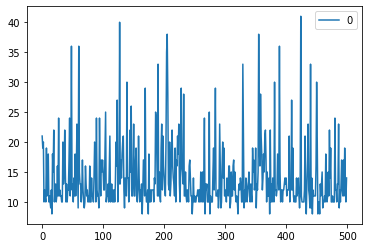

In [342]:
import pandas as pd
import matplotlib as plt

df = pd.DataFrame(len_list)
df.plot()